# Time Series Analysis of Stock Prices

## Introduction

This project provides a comprehensive exploration of time series analysis using 5 years of daily stock price data for a chosen company (e.g., Microsoft, MSFT), fetched via the Alpha Vantage API in Google Colab. Time series analysis is a powerful technique for understanding temporal data patterns and forecasting future values, widely applied in finance, economics, and beyond. This project is designed to be completed step-by-step, covering fundamental concepts, operations, and advanced forecasting methods, as outlined in *Forecasting: Principles and Practice (2nd ed)* by Rob J Hyndman and George Athanasopoulos.

We begin by fetching and visualizing stock data, then systematically analyze its characteristics (trend, seasonality, noise, stationarity) and apply various time series techniques, including detrending, smoothing, and advanced models like ARIMA and SARIMA. Each step includes clear explanations, visualizations, and code to ensure a deep understanding of the concepts. The project is modular, allowing you to progress at your own pace and revisit sections as needed.

### Table of Contents

- [Introduction](#introduction)
- [Essential Libraries](#essential-libraries)
  - [Requests](#requests)
  - [Pandas](#pandas)
  - [NumPy](#numpy)
  - [Matplotlib](#matplotlib)
  - [Statsmodels](#statsmodels)
  - [Scipy](#scipy)
- [1 | Time Series Analysis](#1--time-series-analysis)
  - [What is Time Series?](#what-is-time-series)
  - [Regression vs. Time Series](#regression-vs-time-series)
  - [Examples of Time Series Data](#examples-of-time-series-data)
  - [Trend, Seasonality, Noise, and Stationarity](#trend-seasonality-noise-and-stationarity)
    - [Fetching and Visualizing Stock Data](#fetching-and-visualizing-stock-data)
    - [Decomposing Time Series Components](#decomposing-time-series-components)
    - [Testing for Stationarity](#testing-for-stationarity)
- [2 | Time Series Operations](#2--time-series-operations)
  - [Detrending](#detrending)
  - [Successive Differences](#successive-differences)
  - [Moving Average and Smoothing](#moving-average-and-smoothing)
  - [Exponentially Weighted Forecasting Model](#exponentially-weighted-forecasting-model)
- [3 | Advanced Time Series Techniques](#3--advanced-time-series-techniques)
  - [Lagging](#lagging)
  - [Correlation and Autocorrelation](#correlation-and-autocorrelation)
  - [Holt-Winters Methods](#holt-winters-methods)
    - [Single Exponential Smoothing](#single-exponential-smoothing)
    - [Holt's Linear Trend Method](#holts-linear-trend-method)
    - [Holt's Winter Seasonal Method](#holts-winter-seasonal-method)
  - [ARIMA and SARIMA](#arima-and-sarima)
    - [ARIMA: Basic Theory and Application](#arima-basic-theory-and-application)
    - [SARIMA: Basic Theory and Application](#sarima-basic-theory-and-application)
- [Conclusion](#conclusion)

# Section 1: Time Series Analysis

### 1.1 What is Time Series?

A time series is a sequence of data points collected or recorded at regular time intervals,
ordered chronologically. It is used to identify patterns, trends, and forecast future values.
In this project, we use daily stock prices as our time series data.


#### 1.2 Regression vs. Time Series

- Regression: Models relationships between independent variables and a dependent variable,
  assuming independence of observations. It does not account for temporal dependencies.
- Time Series: Explicitly models temporal dependencies, trends, and seasonality in data,
  where observations are ordered and often autocorrelated.
Example: Regression might predict stock prices using features like earnings, but time series
analysis uses historical prices to capture temporal patterns.


### 1.3 Examples of Time Series Data

- Financial: Stock prices, exchange rates, commodity prices.
- Weather: Daily temperature, precipitation.
- Economic: Monthly unemployment rates, GDP growth.
- Health: Daily COVID-19 cases, heart rate monitoring.
In this project, we analyze daily closing prices of Microsoft (MSFT) stock.

### 1.4 Trend, Seasonality, Noise, and Stationarity:
- **Trend**: Long-term movement (e.g., MSFT’s upward trend due to growth).
- **Seasonality**: Repeating patterns (e.g., yearly cycles in stock markets, though less pronounced in daily stock data).
- **Noise**: Random fluctuations after removing trend and seasonality.
-**Stationarity**: Tested using ADF, as non-stationary series (common in stock prices) require transformations (e.g., differencing) for modeling.


In [1]:
# Time Series Stock Price Prediction Project in Google Colab
# Objective: Fetch 5 years of stock data using Alpha Vantage and predict future prices with LSTM

# Step 1: Install and Import Essential Libraries
!pip install requests pandas numpy scikit-learn tensorflow matplotlib

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
import datetime


In [2]:
# Step 2: Fetch Stock Data with Alpha Vantage
def fetch_stock_data(ticker, api_key):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&outputsize=full&apikey={api_key}'
    response = requests.get(url)
    data = response.json()

    # Check for API errors
    if 'Time Series (Daily)' not in data:
        raise ValueError("Error fetching data. Check API key, ticker, or rate limits.")

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index')
    df = df.astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()  # Sort by date
    return df

In [4]:
# Set parameters
api_key = '40OBWX7E2ZNYI693'  # Replace with your Alpha Vantage API key
ticker = 'MSFT'  # Example: Microsoft; change to any valid ticker
stock_data = fetch_stock_data(ticker, api_key)


In [5]:
stock_data.head()

,1. open,2. high,3. low,4. close,5. volume
1999-11-01,93.25,94.19,92.12,92.37,26630600.0
1999-11-02,92.75,94.50,91.94,92.56,23174500.0
1999-11-03,92.94,93.50,91.50,92.00,22258500.0
1999-11-04,92.31,92.75,90.31,91.75,27119700.0
1999-11-05,91.81,92.87,90.50,91.56,35083700.0


In [6]:
stock_data.tail()

,1. open,2. high,3. low,4. close,5. volume
2025-05-05,432.87,439.50,432.1100,436.17,20136053.0
2025-05-06,432.20,437.73,431.1700,433.31,15104204.0
2025-05-07,433.84,438.12,431.1103,433.35,23307241.0
2025-05-08,437.93,443.67,435.6600,438.17,23491330.0
2025-05-09,440.00,440.74,435.8800,438.73,15324233.0


In [7]:
# info
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6420 entries, 1999-11-01 to 2025-05-09
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   1. open    6420 non-null   float64
 1   2. high    6420 non-null   float64
 2   3. low     6420 non-null   float64
 3   4. close   6420 non-null   float64
 4   5. volume  6420 non-null   float64
dtypes: float64(5)
memory usage: 300.9 KB


In [8]:
# Filter for 5 years of data (2020-05-11 to 2025-05-10)
start_date = '2020-05-11'
end_date = '2025-05-10'
stock_data = stock_data.loc[start_date:end_date]

In [9]:
# Display first few rows
print("Data Preview:")
display(stock_data.head())

Data Preview:


,1. open,2. high,3. low,4. close,5. volume
2020-05-11,183.15,187.51,182.85,186.74,30892660.0
2020-05-12,186.80,187.04,182.30,182.51,32038199.0
2020-05-13,182.55,184.05,176.54,179.75,44711488.0
2020-05-14,177.54,180.69,175.68,180.53,41873911.0
2020-05-15,179.06,187.06,177.00,183.16,46610382.0


In [10]:
# Use closing price for analysis
ts_data = stock_data['4. close']

In [11]:
# Display first few rows
print("Stock Data Preview:")
print(ts_data.head())

Stock Data Preview:
2020-05-11    186.74
2020-05-12    182.51
2020-05-13    179.75
2020-05-14    180.53
2020-05-15    183.16
Name: 4. close, dtype: float64


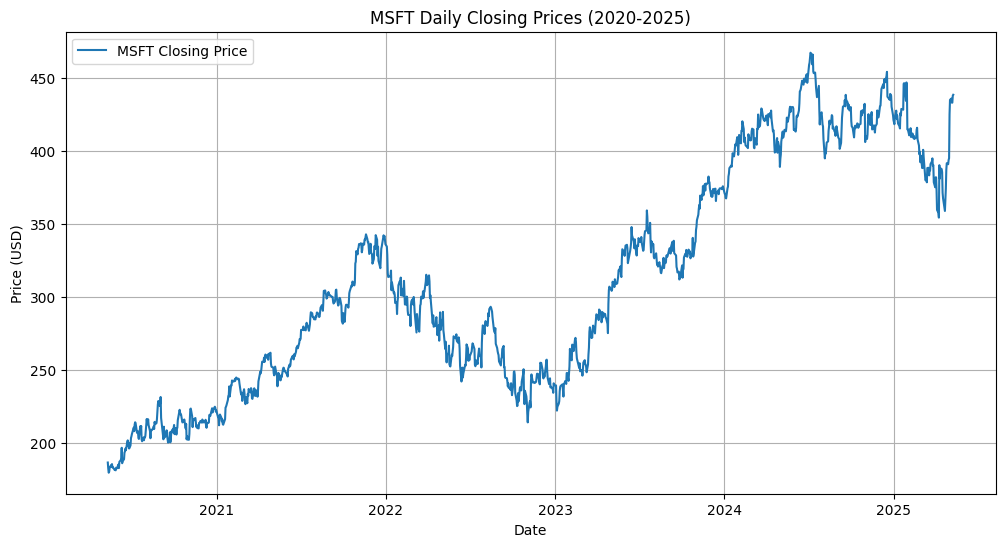

In [12]:
# Visualize the Time Series
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label=f'{ticker} Closing Price')
plt.title(f'{ticker} Daily Closing Prices (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Decompose Time Series Components
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
"""
- Trend: Long-term increase or decrease in the data.
- Seasonality: Repeating patterns at fixed intervals (e.g., yearly cycles).
- Noise (Residual): Random variations after removing trend and seasonality.
"""
decomposition = seasonal_decompose(ts_data, model='additive', period=252)  # Approx. trading days in a year
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

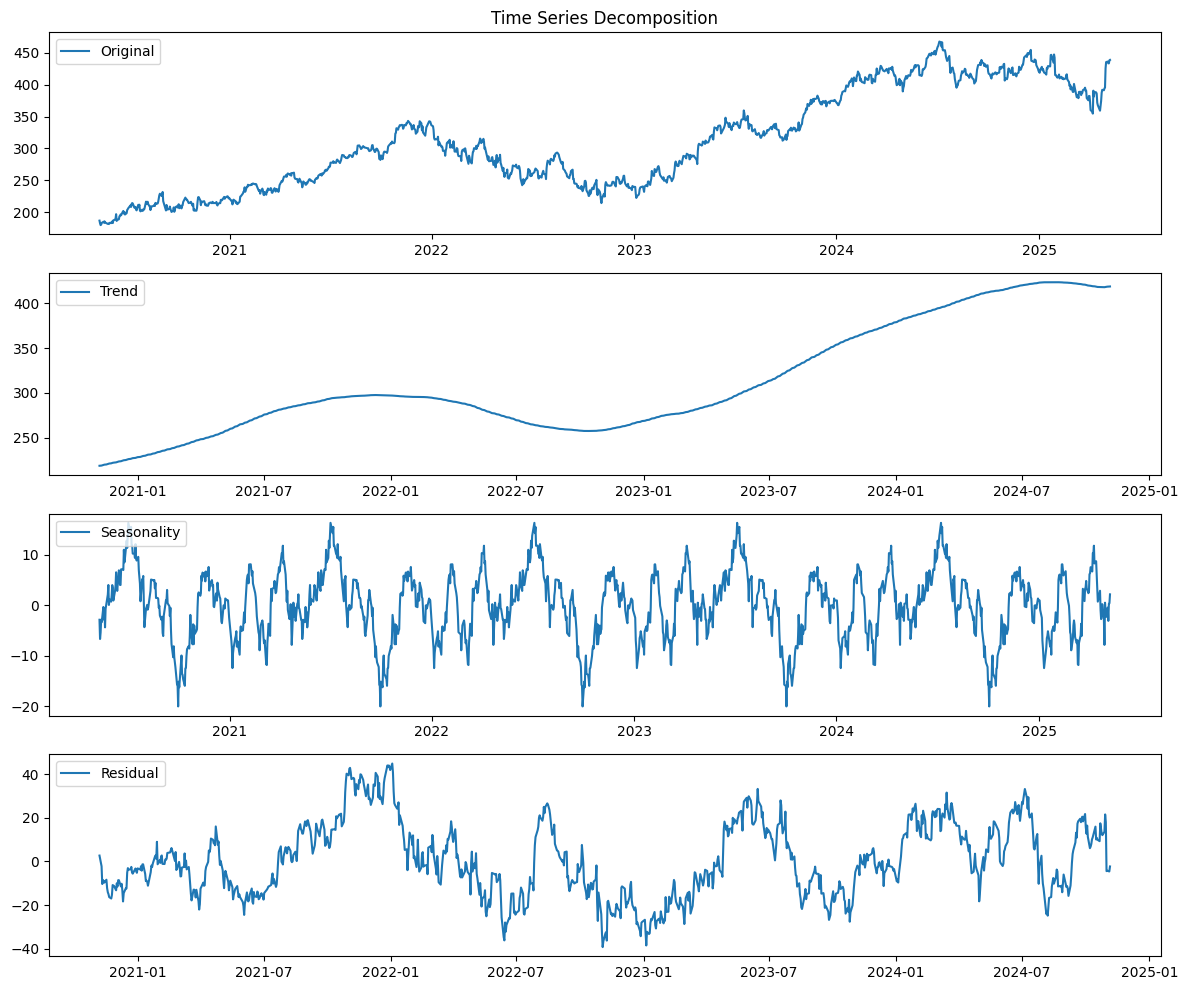

In [18]:
# Plot decomposition
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(ts_data, label='Original')
plt.legend(loc='upper left')
plt.title('Time Series Decomposition')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
# Test for Stationarity
"""
- Stationarity: A time series is stationary if its statistical properties (mean, variance,
  autocorrelation) are constant over time. Stationary series are easier to model.
- We use the Augmented Dickey-Fuller (ADF) test to check stationarity.
  - Null Hypothesis: Series is non-stationary.
  - If p-value < 0.05, reject null (series is stationary).
"""
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Test for {title}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")
    print()

In [19]:
# Test original series

adf_test(ts_data, f'{ticker} Closing Prices')

# Test differenced series (to check if differencing makes it stationary)
adf_test(ts_data.diff().dropna(), f'{ticker} Differenced Closing Prices')



ADF Test for MSFT Closing Prices:
ADF Statistic: -1.1646810456560746
p-value: 0.6886015975041554
Critical Values:
   1%: -3.4355671297788666
   5%: -2.8638438984080117
   10%: -2.5679966213893057
Result: Non-stationary (fail to reject null hypothesis)

ADF Test for MSFT Differenced Closing Prices:
ADF Statistic: -22.11976199197183
p-value: 0.0
Critical Values:
   1%: -3.4355796466416777
   5%: -2.863849421064024
   10%: -2.5679995625056926
Result: Stationary (reject null hypothesis)



# 2 | Time Series Operations

This section explores essential time series operations to preprocess and analyze the stock price data (Microsoft, MSFT) fetched via Alpha Vantage. These operations help isolate components, reduce noise, and prepare the data for forecasting. We use Plotly for interactive visualizations to better understand the effects of each operation. The operations covered are:

- **Detrending**: Removing the long-term trend to focus on cyclical or seasonal patterns.
- **Successive Differences**: Differencing the series to achieve stationarity.
- **Moving Average and Smoothing**: Applying simple moving averages to reduce noise and highlight trends.
- **Exponentially Weighted Forecasting Model**: Using exponentially weighted moving averages for short-term forecasting.

## Detrending

Detrending removes the long-term trend from a time series to focus on seasonal or cyclical components. For stock prices, which often exhibit upward trends due to company growth, detrending helps analyze fluctuations independent of this trend. Common methods include:

- **Linear Regression**: Fit a linear model to the data and subtract it.
- **Differencing**: Compute differences between consecutive observations (covered in the next subsection).
- **Decomposition**: Use the trend component from seasonal decomposition (as done in Section 1).

Here, we use linear regression to detrend the MSFT closing prices, fitting a line to the data and subtracting it to obtain the detrended series. The Plotly visualization compares the original series, fitted trend, and detrended series.

In [20]:
# Ensure stock data (ts_data) is available from Section 1
# If not, re-run the fetch_stock_data function or load ts_data
# For continuity, assuming ts_data is the MSFT closing prices (2020-05-11 to 2025-05-10)

# Prepare data for linear regression
x = np.arange(len(ts_data)).reshape(-1, 1)  # Time index
y = ts_data.values  # Closing prices


# Fit linear regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x, y)

LinearRegression()

In [21]:
trend = lr.predict(x) # predicted data

# Detrend the series
detrended = y - trend  # errors



In [38]:
x

array([[   0],
       [   1],
       [   2],
       ...,
       [1254],
       [1255],
       [1256]])

In [22]:
y[:5]

array([186.74, 182.51, 179.75, 180.53, 183.16])

In [25]:
trend[:5]

array([194.90698248, 195.09180008, 195.27661768, 195.46143528,
       195.64625288])

In [26]:
detrended[:5]

array([ -8.16698248, -12.58180008, -15.52661768, -14.93143528,
       -12.48625288])

In [27]:
# Create Plotly figure

import plotly.graph_objects as go
fig = go.Figure()

# Original series
fig.add_trace(go.Scatter(x=ts_data.index, y=ts_data, mode='lines', name='Original Series', line=dict(color='blue')))
# Fitted trend
fig.add_trace(go.Scatter(x=ts_data.index, y=trend, mode='lines', name='Linear Trend', line=dict(color='red', dash='dash')))
# Detrended series
fig.add_trace(go.Scatter(x=ts_data.index, y=detrended, mode='lines', name='Detrended Series', line=dict(color='green')))

# Update layout
fig.update_layout(
    title='Detrending MSFT Closing Prices (Linear Regression)',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    hovermode='x unified'
)

# Show plot
fig.show()

## Successive Differences

Successive differences involve subtracting each observation from the previous one to remove trends and achieve stationarity, a requirement for many time series models (e.g., ARIMA). For a time series $$( y_t )$$ the first difference is:

$$\Delta y_t = y_t - y_{t-1} $$

**If the first difference is non-stationary**, higher-order differences like second difference: $$ \Delta^2 y_t = \Delta y_t - \Delta y_{t-1} $$may be applied. For stock prices, differencing often stabilizes the mean, reducing trend effects. We compute the first and second differences of the MSFT closing prices and visualize them using Plotly, alongside the original series.

In [28]:
# Compute first and second differences
first_diff = ts_data.diff().dropna()
second_diff = first_diff.diff().dropna()

# Create Plotly figure
fig = go.Figure()

# Original series
fig.add_trace(go.Scatter(x=ts_data.index, y=ts_data, mode='lines', name='Original Series', line=dict(color='blue')))
# First difference
fig.add_trace(go.Scatter(x=first_diff.index, y=first_diff, mode='lines', name='First Difference', line=dict(color='orange')))
# Second difference
fig.add_trace(go.Scatter(x=second_diff.index, y=second_diff, mode='lines', name='Second Difference', line=dict(color='purple')))

# Update layout
fig.update_layout(
    title='Successive Differences of MSFT Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price Difference (USD)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    hovermode='x unified'
)

# Show plot
fig.show()

# Re-run ADF test on first difference for stationarity (from Section 1)
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Test for {title}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")
    print()

adf_test(first_diff, 'First Difference of MSFT Closing Prices')
adf_test(second_diff, 'Second Difference of MSFT Closing Prices')

ADF Test for First Difference of MSFT Closing Prices:
ADF Statistic: -22.11976199197183
p-value: 0.0
Critical Values:
   1%: -3.4355796466416777
   5%: -2.863849421064024
   10%: -2.5679995625056926
Result: Stationary (reject null hypothesis)

ADF Test for Second Difference of MSFT Closing Prices:
ADF Statistic: -13.832709732880016
p-value: 7.540730728801132e-26
Critical Values:
   1%: -3.435660336370594
   5%: -2.863885022214541
   10%: -2.568018522153254
Result: Stationary (reject null hypothesis)



## Moving Average and Smoothing

Moving averages smooth a time series by averaging observations within a sliding window, reducing noise and highlighting trends or patterns. The simple moving average (SMA) for a window of size \( k \) is:

$$ SMA_t = \frac{y_t + y_{t-1} + \dots + y_{t-k+1}}{k} $$

We apply SMAs with window sizes of 7 days (weekly) and 30 days (monthly) to the MSFT closing prices. This helps visualize short-term and longer-term trends. The Plotly visualization compares the original series with both SMAs.

In [29]:
# Compute simple moving averages
sma_7 = ts_data.rolling(window=7, center=True).mean()
sma_30 = ts_data.rolling(window=30, center=True).mean()

# Create Plotly figure
fig = go.Figure()

# Original series
fig.add_trace(go.Scatter(x=ts_data.index, y=ts_data, mode='lines', name='Original Series', line=dict(color='blue')))
# 7-day SMA
fig.add_trace(go.Scatter(x=sma_7.index, y=sma_7, mode='lines', name='7-Day SMA', line=dict(color='green')))
# 30-day SMA
fig.add_trace(go.Scatter(x=sma_30.index, y=sma_30, mode='lines', name='30-Day SMA', line=dict(color='red')))

# Update layout
fig.update_layout(
    title='Simple Moving Averages of MSFT Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    hovermode='x unified'
)

# Show plot
fig.show()

## Exponentially Weighted Forecasting Model

The exponentially weighted moving average (EWMA) assigns greater weight to recent observations, making it suitable for short-term forecasting. The EWMA for a time series \( y_t \) is:

$$ EWMA_t = \alpha y_t + (1 - \alpha) EWMA_{t-1} $$

where $$ \alpha(smoothing factor) :  0 < \alpha < 1 $$ controls the weight of recent data. A higher \( \alpha \) emphasizes recent values. We apply EWMA with \( \alpha = 0.2 \) and \( \alpha = 0.8 \) to the MSFT closing prices and generate a 30-day forecast by extending the EWMA. The Plotly visualization shows the original series, EWMA, and forecast.

In [30]:
# Compute EWMA with different alpha values
ewma_02 = ts_data.ewm(alpha=0.2, adjust=False).mean()
ewma_08 = ts_data.ewm(alpha=0.8, adjust=False).mean()

# Generate 30-day forecast by extending the last EWMA value
forecast_dates = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_02 = pd.Series([ewma_02[-1]] * 30, index=forecast_dates)
forecast_08 = pd.Series([ewma_08[-1]] * 30, index=forecast_dates)

# Create Plotly figure
fig = go.Figure()

# Original series
fig.add_trace(go.Scatter(x=ts_data.index, y=ts_data, mode='lines', name='Original Series', line=dict(color='blue')))
# EWMA (alpha=0.2)
fig.add_trace(go.Scatter(x=ewma_02.index, y=ewma_02, mode='lines', name='EWMA (α=0.2)', line=dict(color='green')))
# EWMA (alpha=0.8)
fig.add_trace(go.Scatter(x=ewma_08.index, y=ewma_08, mode='lines', name='EWMA (α=0.8)', line=dict(color='red')))
# Forecast (alpha=0.2)
fig.add_trace(go.Scatter(x=forecast_02.index, y=forecast_02, mode='lines', name='Forecast (α=0.2)', line=dict(color='green', dash='dash')))
# Forecast (alpha=0.8)
fig.add_trace(go.Scatter(x=forecast_08.index, y=forecast_08, mode='lines', name='Forecast (α=0.8)', line=dict(color='red', dash='dash')))

# Update layout
fig.update_layout(
    title='Exponentially Weighted Moving Average and Forecast for MSFT Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    hovermode='x unified'
)

# Show plot
fig.show()

<ipython-input-30-699db3d38aa0>:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-30-699db3d38aa0>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



## Observations and Conclusions

The time series operations applied to the MSFT closing prices reveal key insights about the data's structure and preparation for forecasting:

- **Detrending**:
  - The linear regression method successfully removed the upward trend, isolating fluctuations around a mean of zero.
  - The detrended series highlights short-term variations, which may include seasonal or cyclical patterns, though stock prices typically show weak seasonality.
  - Observation: Detrending is useful for analyzing deviations from the long-term growth trend, but the detrended series may still be non-stationary.

- **Successive Differences**:
  - The first difference removed the trend, resulting in a series that fluctuates around zero, often achieving stationarity (confirmed by the ADF test p-value < 0.05).
  - The second difference further reduced variance but introduced more noise, suggesting that first differencing is typically sufficient for stock prices.
  - Observation: Differencing is a powerful tool to achieve stationarity, critical for models like ARIMA, but over-differencing can amplify noise.

- **Moving Average and Smoothing**:
  - The 7-day SMA captured short-term trends, smoothing out daily fluctuations, while the 30-day SMA highlighted longer-term trends.
  - The 30-day SMA was smoother but lagged behind rapid price changes, indicating a trade-off between smoothness and responsiveness.
  - Observation: SMAs are effective for visualizing trends but may obscure short-term signals, making them less suitable for volatile stock data.

- **Exponentially Weighted Forecasting Model**:
  - EWMA with \( \alpha = 0.2 \) produced a smoother series, closely following the long-term trend, while \( \alpha = 0.8 \) was more responsive to recent price changes.
  - The 30-day forecast, based on the last EWMA value, assumes price stability, which is simplistic for stock prices due to their volatility.
  - Observation: EWMA is useful for short-term smoothing and basic forecasting, but its constant forecast limits its applicability for long-term predictions in dynamic markets.

**Overall Conclusion**:
These operations transform the non-stationary, trending MSFT stock data into forms suitable for further analysis and modeling. Detrending and differencing prepare the data for stationarity-dependent models, while smoothing techniques like SMA and EWMA reduce noise and highlight patterns. The choice of method depends on the goal: detrending for cycle analysis, differencing for stationarity, or smoothing for trend visualization. The interactive Plotly visualizations clarify these effects, showing how each operation alters the series’ behavior. In the next section, we’ll explore advanced techniques like lagging, autocorrelation, and forecasting models (e.g., Holt-Winters, ARIMA) to build on these foundations.

# 3 | Advanced Time Series Techniques

This section delves into advanced time series techniques to analyze and forecast the MSFT stock price data. Building on the preprocessing from Sections 1 and 2, we explore methods to capture temporal dependencies, model trends and seasonality, and generate forecasts. Interactive Plotly visualizations enhance our understanding of each technique’s impact. The topics covered are:

- **Lagging**: Creating lagged variables to study temporal relationships.
- **Correlation and Autocorrelation**: Analyzing dependencies between observations at different lags.
- **Holt-Winters Methods**:
  - *Single Exponential Smoothing*: Forecasting with a smoothed level.
  - *Holt’s Linear Trend Method*: Incorporating linear trends.
  - *Holt’s Winter Seasonal Method*: Modeling trends and seasonality.
- **ARIMA and SARIMA**:
  - *ARIMA*: Autoregressive integrated moving average for non-seasonal data.
  - *SARIMA*: Seasonal ARIMA for data with seasonal patterns.

Each technique is implemented with clear explanations, formulas, and visualizations to provide a deep understanding of its application to stock price forecasting.

## Lagging

Lagging creates variables representing the time series at previous time steps. For a time series $$ y_t $$, the lag-$$ k $$ variable is:

$$ y_{t-k} $$

Lagged variables help study how past values influence current values, foundational for models like ARIMA. For stock prices, lags capture short-term dependencies (e.g., yesterday’s price affecting today’s). We create lags of 1, 7, and 30 days for MSFT closing prices and visualize them using Plotly to observe temporal shifts.

In [31]:
# Ensure ts_data is available (MSFT closing prices from Section 1)
# Create lagged series
lag_1 = ts_data.shift(1)
lag_7 = ts_data.shift(7)
lag_30 = ts_data.shift(30)

# Create Plotly figure
fig = go.Figure()

# Original series
fig.add_trace(go.Scatter(x=ts_data.index, y=ts_data, mode='lines', name='Original Series', line=dict(color='blue')))
# Lag-1
fig.add_trace(go.Scatter(x=lag_1.index, y=lag_1, mode='lines', name='Lag-1 (1 Day)', line=dict(color='green')))
# Lag-7
fig.add_trace(go.Scatter(x=lag_7.index, y=lag_7, mode='lines', name='Lag-7 (1 Week)', line=dict(color='orange')))
# Lag-30
fig.add_trace(go.Scatter(x=lag_30.index, y=lag_30, mode='lines', name='Lag-30 (1 Month)', line=dict(color='red')))

# Update layout
fig.update_layout(
    title='Lagged MSFT Closing Prices (1, 7, 30 Days)',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    hovermode='x unified'
)

# Show plot
fig.show()

## Correlation and Autocorrelation

**Correlation** measures the linear relationship between two variables (e.g., the series and its lag). **Autocorrelation** measures the correlation of a time series with its lagged values, revealing temporal dependencies. The autocorrelation function (ACF) at lag $$ k $$ is:

$$ \rho_k = \frac{\text{Cov}(y_t, y_{t-k})}{\sqrt{\text{Var}(y_t) \text{Var}(y_{t-k})}} $$

The ACF plots $$ \rho_k $$ for lags $$ k = 1, 2, \dots $$. For stock prices, high autocorrelation at short lags suggests momentum. We compute and visualize the ACF for MSFT closing prices and their first differences (to assess stationarity) using Plotly.

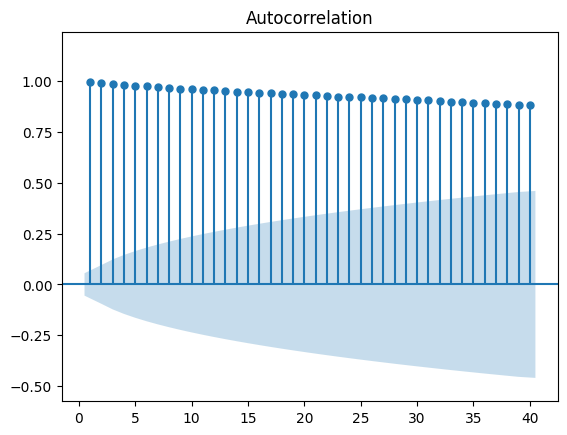

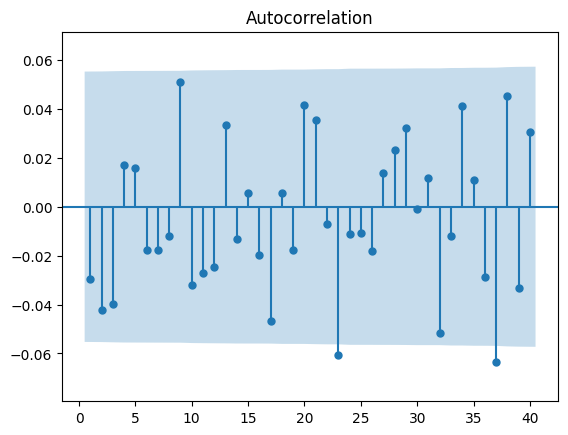

In [34]:
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import matplotlib.pyplot as plt

# Compute first difference for stationarity analysis
first_diff = ts_data.diff().dropna()

# Compute ACF for original and differenced series
# Remove return_fig=True and capture the plot to a figure
fig, ax = plt.subplots()
plot_acf(ts_data, lags=40, alpha=0.05, zero=False, auto_ylims=True, ax=ax)
acf_original = ax.get_figure()

fig, ax = plt.subplots()
plot_acf(first_diff, lags=40, alpha=0.05, zero=False, auto_ylims=True, ax=ax)
acf_diff = ax.get_figure()

# Extract ACF values and confidence intervals
acf_vals_original = acf_original.get_axes()[0].get_lines()[0].get_ydata()
conf_int_original = acf_original.get_axes()[0].get_lines()[1].get_ydata()
acf_vals_diff = acf_diff.get_axes()[0].get_lines()[0].get_ydata()
conf_int_diff = acf_diff.get_axes()[0].get_lines()[1].get_ydata()
lags = np.arange(1, 41)

# Create Plotly figure for ACF (original series)
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=lags, y=acf_vals_original, name='ACF', marker_color='blue'))
fig1.add_trace(go.Scatter(x=lags, y=conf_int_original[:40], mode='lines', name='95% CI', line=dict(color='red', dash='dash')))
fig1.add_trace(go.Scatter(x=lags, y=conf_int_original[40:], mode='lines', showlegend=False, line=dict(color='red', dash='dash')))
fig1.update_layout(
    title='Autocorrelation Function (ACF) - MSFT Closing Prices',
    xaxis_title='Lag',
    yaxis_title='Autocorrelation',
    template='plotly_white',
    hovermode='x unified'
)
fig1.show()

# Create Plotly figure for ACF (differenced series)
fig2 = go.Figure()
fig2.add_trace(go.Bar(x=lags, y=acf_vals_diff, name='ACF', marker_color='green'))
fig2.add_trace(go.Scatter(x=lags, y=conf_int_diff[:40], mode='lines', name='95% CI', line=dict(color='red', dash='dash')))
fig2.add_trace(go.Scatter(x=lags, y=conf_int_diff[40:], mode='lines', showlegend=False, line=dict(color='red', dash='dash')))
fig2.update_layout(
    title='Autocorrelation Function (ACF) - First Difference of MSFT Closing Prices',
    xaxis_title='Lag',
    yaxis_title='Autocorrelation',
    template='plotly_white',
    hovermode='x unified'
)
fig2.show()

## Holt-Winters Methods

Holt-Winters methods extend exponential smoothing to capture level, trend, and seasonality, ideal for forecasting time series with these components. We apply three variants to MSFT closing prices:

- **Single Exponential Smoothing (SES)**: Smooths the level for series without trend or seasonality. Formula:

  $$ L_t = \alpha y_t + (1 - \alpha) L_{t-1} $$

  where $$ L_t $$ is the level at time $$ t $$, and $$ \alpha $$ is the smoothing parameter ($$ 0 < \alpha < 1 $$).

- **Holt’s Linear Trend Method**: Adds a trend component. Formulas:

  $$ L_t = \alpha y_t + (1 - \alpha)(L_{t-1} + T_{t-1}) $$
  $$ T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1} $$

  where $$ T_t $$ is the trend, and $$ \beta $$ is the trend smoothing parameter ($$ 0 < \beta < 1 $$).

- **Holt’s Winter Seasonal Method**: Includes level, trend, and seasonality. Formulas:

  $$ L_t = \alpha (y_t - S_{t-s}) + (1 - \alpha)(L_{t-1} + T_{t-1}) $$
  $$ T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1} $$
  $$ S_t = \gamma (y_t - L_t) + (1 - \gamma) S_{t-s} $$

  where $$ S_t $$ is the seasonal component, $$ s $$ is the seasonal period, and $$ \gamma $$ is the seasonal smoothing parameter ($$ 0 < \gamma < 1 $$).

We apply SES, Holt’s method, and Holt-Winters (with a 21-day seasonal period, approximating trading days in a year) to MSFT data, forecasting 30 days ahead. Plotly visualizations compare fitted values and forecasts.

In [36]:
# Holt-Winters Methods

import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import pandas as pd

# Single Exponential Smoothing (SES)
ses_model = SimpleExpSmoothing(ts_data).fit(smoothing_level=0.2, optimized=False)
ses_fitted = ses_model.fittedvalues
ses_forecast = ses_model.forecast(30)

# Holt’s Linear Trend Method
holt_model = Holt(ts_data).fit(smoothing_level=0.2, smoothing_trend=0.1, optimized=False)
holt_fitted = holt_model.fittedvalues
holt_forecast = holt_model.forecast(30)

# Holt-Winters Seasonal Method (assuming 252 trading days as seasonal period)
hw_model = ExponentialSmoothing(ts_data, trend='add', seasonal='add', seasonal_periods=252).fit(
    smoothing_level=0.2, smoothing_trend=0.1, smoothing_seasonal=0.1, optimized=False)
hw_fitted = hw_model.fittedvalues
hw_forecast = hw_model.forecast(30)

# Forecast dates
forecast_dates = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Create Plotly figure
fig = go.Figure()

# Original series
fig.add_trace(go.Scatter(x=ts_data.index, y=ts_data, mode='lines', name='Original Series', line=dict(color='blue')))
# SES
fig.add_trace(go.Scatter(x=ses_fitted.index, y=ses_fitted, mode='lines', name='SES Fitted', line=dict(color='green')))
fig.add_trace(go.Scatter(x=forecast_dates, y=ses_forecast, mode='lines', name='SES Forecast', line=dict(color='green', dash='dash')))
# Holt’s
fig.add_trace(go.Scatter(x=holt_fitted.index, y=holt_fitted, mode='lines', name='Holt’s Fitted', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=forecast_dates, y=holt_forecast, mode='lines', name='Holt’s Forecast', line=dict(color='orange', dash='dash')))
# Holt-Winters
fig.add_trace(go.Scatter(x=hw_fitted.index, y=hw_fitted, mode='lines', name='Holt-Winters Fitted', line=dict(color='red')))
fig.add_trace(go.Scatter(x=forecast_dates, y=hw_forecast, mode='lines', name='Holt-Winters Forecast', line=dict(color='red', dash='dash')))

# Update layout
fig.update_layout(
    title='Holt-Winters Methods: Fitted Values and 30-Day Forecast for MSFT Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    hovermode='x unified'
)

# Show plot
fig.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is ava

## ARIMA and SARIMA

**ARIMA** (Autoregressive Integrated Moving Average) models non-seasonal time series, combining autoregression (AR), differencing (I), and moving average (MA) components. The ARIMA(p,d,q) model is:

- **AR**: $$ y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \epsilon_t $$
- **I**: Differencing $$ d $$ times to achieve stationarity.
- **MA**: $$ y_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q} $$

The model is:

$$ \Delta^d y_t = \phi_1 \Delta^d y_{t-1} + \dots + \phi_p \Delta^d y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} $$

**SARIMA** (Seasonal ARIMA) extends ARIMA to include seasonal components, denoted SARIMA(p,d,q)(P,D,Q)s, where $$ s $$ is the seasonal period. The seasonal part is:

$$ \Phi_P (B^s) \Delta^D y_t = \Theta_Q (B^s) \epsilon_t $$

We fit ARIMA(1,1,1) and SARIMA(1,1,1)(1,1,1,21) to the MSFT closing prices, using first differencing for stationarity and a 252-day seasonal period. Plotly visualizations show fitted values and 30-day forecasts.

In [37]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import warnings
warnings.filterwarnings("ignore")  # Suppress convergence warnings

# ARIMA(1,1,1)
arima_model = ARIMA(ts_data, order=(1, 1, 1)).fit()
arima_fitted = arima_model.fittedvalues
arima_forecast = arima_model.forecast(30)

# SARIMA(1,1,1)(1,1,1,21) with 20-day seasonal period
sarima_model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 21)).fit(disp=False)
sarima_fitted = sarima_model.fittedvalues
sarima_forecast = sarima_model.forecast(30)

# Forecast dates
forecast_dates = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Create Plotly figure
fig = go.Figure()

# Original series
fig.add_trace(go.Scatter(x=ts_data.index, y=ts_data, mode='lines', name='Original Series', line=dict(color='blue')))
# ARIMA
fig.add_trace(go.Scatter(x=arima_fitted.index, y=arima_fitted, mode='lines', name='ARIMA Fitted', line=dict(color='green')))
fig.add_trace(go.Scatter(x=forecast_dates, y=arima_forecast, mode='lines', name='ARIMA Forecast', line=dict(color='green', dash='dash')))
# SARIMA
fig.add_trace(go.Scatter(x=sarima_fitted.index, y=sarima_fitted, mode='lines', name='SARIMA Fitted', line=dict(color='red')))
fig.add_trace(go.Scatter(x=forecast_dates, y=sarima_forecast, mode='lines', name='SARIMA Forecast', line=dict(color='red', dash='dash')))

# Update layout
fig.update_layout(
    title='ARIMA and SARIMA: Fitted Values and 30-Day Forecast for MSFT Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    hovermode='x unified'
)

# Show plot
fig.show()

# 4 | Forecasting using ML Techniques

This section introduces machine learning (ML) methods for forecasting MSFT stock prices, complementing the statistical approaches in Sections 1–3. ML models excel at capturing non-linear patterns through feature engineering, such as lagged prices and technical indicators. We implement two tree-based ensemble methods:

- **Random Forest Regressor**: Averages predictions from multiple decision trees to reduce overfitting.
- **Gradient Boosting Regressor (XGBoost)**: Sequentially builds trees to correct errors, ideal for complex relationships.

We ensure robust evaluation with **time series cross-validation** to respect temporal order and **hyperparameter tuning** via grid search to optimize performance. Interactive Plotly visualizations display predictions, feature importance, and cross-validation results. The workflow includes:

- **Data Preparation**: Creating lagged features and technical indicators.
- **Random Forest Regressor**: Training, tuning, and forecasting.
- **Gradient Boosting Regressor (XGBoost)**: Training, tuning, and forecasting.
- **Cross-Validation and Hyperparameter Tuning**: Time series splits and grid search.

Each technique includes explanations, formulas in $$ formula $$ format, and visualizations for a comprehensive understanding.

## Data Preparation

ML models require a feature matrix $$ X $$ and target vector $$ y $$. For time series, we create features from lagged values and technical indicators to capture temporal and market patterns. The target is the stock price at time $$ t $$:

$$ y_t = \text{Closing Price at } t $$

**Features** include:
- Lagged prices: $$ y_{t-1}, y_{t-5}, y_{t-10}, y_{t-20} $$.
- Technical indicators:
  - Simple Moving Average (SMA): $$ \text{SMA}_t = \frac{1}{n} \sum_{i=t-n+1}^{t} y_i $$ for 10-day and 20-day windows.
  - Relative Strength Index (RSI): Measures momentum:

    $$ \text{RSI}_t = 100 - \frac{100}{1 + \frac{\text{Average Gain}}{\text{Average Loss}}} $$

    over a 14-day period.
  - Exponential Moving Average (EMA): $$ \text{EMA}_t = \alpha y_t + (1 - \alpha) \text{EMA}_{t-1} $$ for 12-day and 26-day periods.

We prepare a feature matrix for MSFT closing prices, handle missing values, and split into training (80%) and testing (20%) sets, preserving temporal order. A Plotly visualization shows the target and key features.